# Kernel Principal Component Analysis Outlier Detector (KPCA-OD)

----

**Created by**:

- **Author**: Dr. Saad Laouadi
- **Date**: 11/08/2024

This notebook was created by **dr. Saad Laouadi** on August 18th, 2024 as part of a series on anomaly detection algorithms. The content is designed for researchers, data scientists, and practitioners interested in applying the KPCA Outlier Detector algorithm to identify anomalies in a dataset.

**Copyright**

**© 2024 Dr. Saad Laouadi. All rights reserved.**

---

## Table of Contents

## Table of Contents
1. [Objective](#Objective)
2. [Prerequisites](#Prerequisites)
3. [Theoretical Background of k-Nearest Neighbors for Outlier Detection (kNN)](#Theoretical-Background-of-KNN-Outlier-Detector)
    - [1. Introduction](#1-Introduction)
    - [2. Core Components](#2.-Core-Components)
       - [2.1 K-Nearest Neighbors Algorithm](#2.1-K-Nearest-Neighbors-Algorithm)
       - [2.2 Distance Metrics](#2.2-Distance-Metrics)
       - [2.3 Anomaly Score Calculation](#2.3-Anomaly-Score-Calculation)
       - [2.4 Local Outlier Factor (LOF)](#2.4-Local-Outlier-Factor-(LOF))
4. [Theoretical Underpinnings](#3.-Theoretical-Underpinnings)
   - [4.1 Unsupervised Learning Theory](#3.1-Unsupervised-Learning-Theory)
   - [4.2 Proximity-Based Outlier Detection](#3.2-Proximity-Based-Outlier-Detection)
   - [4.3 Statistical Distance Theory](#3.3-Statistical-Distance-Theory)
5. [Mathematical Framework](#4.-Mathematical-Framework)
   - [5.1 K-Nearest Neighbors Model](#41-k-nearest-neighbors-model)
   - [5.2 Local Outlier Factor](#42-local-outlier-factor)
   - [5.3 Anomaly Classification](#43-anomaly-classification)
6. [Computational Complexity](#5.-Computational-Complexity)
7. [Using kNN for Outlier Detection Using PyOD Framework](#Using-k-Nearest-Neighbors-(kNN)-for-Outlier-Detection-Using-PyOD-Framework)
   - 7.1. [Key Parameters of kNN](#Key-Parameters-of-kNN)
   - 7.2. [Methods in kNN](#Methods-in-kNN)
   - 7.3. [Training Workflow for kNN](#Training-Workflow-for-kNN)
8. [Practical Example of kNN System with Simulated Data](#Practical-Example-of-k-Nearest-Neighbors-(kNN)-for-Outlier-Detection-with-Simulated-Data)
9. [Real-World Example](#Real-World-Example)
10. [Training kNN as an Unsupervised Problem](#Training-k-Nearest-Neighbors-(kNN)-for-Unsupervised-Outlier-Detection)
11. [Fine-Tune KNN Algorithm](#Fine-Tune-KNN-Algorithm)

---

## Objective

The primary objective of this notebook is to provide a comprehensive exploration of the Kernel Principal Component Analysis (Kernel PCA) Outlier Detector algorithm, encompassing its theoretical foundations, practical implementation, and performance evaluation. Specifically, this notebook aims to:

1. **Elucidate the Theoretical Framework**: Present a detailed explanation of the underlying principles of Kernel PCA and its application to outlier detection, including the concepts of kernel function, non-linear principal components, and reconstruction error.

2. **Demonstrate Practical Implementation**: Guide readers through the step-by-step process of implementing Kernel PCA Outlier Detector using popular `pyod` library. 

3. **Explore Hyperparameter Tuning**: Investigate the impact of various hyperparameters, particularly the choice of kernel function and the number of principal components, on the Kernel PCA Outlier Detector's performance, providing insights into optimal configuration for different types of datasets.

4. **Analyze Performance**: Evaluate Kernel PCA Outlier Detector's effectiveness in identifying outliers using both synthetic and real-world datasets, employing appropriate evaluation metrics and visualization techniques.

5. **Compare with Other Techniques**: Benchmark Kernel PCA Outlier Detector against other outlier detection methods, including linear PCA-based techniques, to highlight its strengths in handling non-linear relationships and complex data structures.

6. **Discuss Real-World Applications**: Present case studies demonstrating Kernel PCA Outlier Detector's applicability in various domains, such as image processing, financial fraud detection, or identifying unusual patterns in sensor data.

7. **Address Challenges and Limitations**: Discuss potential challenges in implementing Kernel PCA Outlier Detector, including its computational complexity, the sensitivity to the choice of kernel function, and the interpretability of results in high-dimensional spaces.

8. **Explore Extensions and Variants**: Introduce readers to advanced topics related to Kernel PCA-based outlier detection, such as the use of sparse and efficient kernel approximations, and the integration of Kernel PCA with other outlier detection techniques.

**By the end of this notebook, readers will have gained a thorough understanding of the Kernel PCA Outlier Detector, equipped with the knowledge and practical skills to apply this algorithm effectively in their own anomaly detection tasks involving non-linear and high-dimensional data.**

### Prerequisites

This notebook assumes a foundational understanding of Python tools for data manipulation and processing. The following prerequisites will help you get the most out of this material:

1. **Data Manipulation**:
   - Familiarity with reading and writing data using libraries such as **Pandas** and **NumPy**.

2. **Machine Learning Workflow**:
   - Prior experience with the **Scikit-learn** library, including:
     - Preprocessing techniques like scaling and normalization.
     - Splitting data into training and test sets using tools like `train_test_split`.

3. **Data Visualization**:
   - Proficiency in using plotting libraries such as **Matplotlib** and **Seaborn** for visualizing data and model results.

In [1]:
# ============================================================================================# 
#                                 Environment Setup
#  Here we import all the necessary modules and tools we will use through this notebook
# ============================================================================================# 
import os
import sys
import time
from collections import Counter

import numpy as np 
import pandas as pd
from scipy.io import arff

from pyod.models.kpca import KPCA
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.auto_encoder import AutoEncoder

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA as skpca

from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_circles, make_moons


from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

# The utils module is not an installable package, it is the same directory as this notebook
from utils import generate_data, visualize_data, apply_abod, apply_abod_advanced, precision_at_rank_n
from utils import grid_search_abod, hyperopt_objective, plot_outliers_vs_inliers
from utils import preprocess_pipeline

from suod_utils import generate_sample_data, evaluate_model, visualize_results

from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data, get_outliers_inliers, evaluate_print
from pyod.utils.example import visualize

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

def print_banner(sep, nchar, title):
    print(sep * nchar)
    print(title.center(nchar))
    print(sep * nchar)

# Configuration 
DATA_PATH = "../../datasets/HeartDisease/HeartDisease_withoutdupl_norm_44.arff"

# Theoretical Background of Kernel PCA Outlier Detector

## 1. Introduction
Kernel Principal Component Analysis Outlier Detector (Kernel PCA-OD) is an unsupervised machine learning algorithm designed for detecting anomalies or outliers in complex, high-dimensional datasets. It leverages the non-linear dimensionality reduction capabilities of Kernel PCA to identify data points that significantly deviate from the main patterns in the data.

Kernel PCA-OD operates on the assumption that normal data points lie close to the principal subspace defined by the top Kernel principal components, while anomalies are located far from this subspace. By examining the reconstruction error or the distance to the Kernel principal subspace, the algorithm can quantify how much a point differs from the main data distribution.

The fundamental premise underlying Kernel PCA-OD's effectiveness is rooted in the concept of non-linear variance explanation. While normal data points are well-represented by the top Kernel principal components, outliers often require additional components to be accurately reconstructed. This difference in non-linear representation forms the basis for anomaly identification.

By exploiting this principle, Kernel PCA-OD offers a powerful tool for detecting anomalies in high-dimensional spaces with complex, non-linear relationships, where traditional distance-based methods or linear PCA-based techniques may falter. Its ability to capture global non-linear patterns in data makes it particularly suited for datasets with intricate correlations across features, from image processing to financial fraud detection.

## 2. Core Components

### 2.1 Kernel Principal Component Analysis
The Kernel PCA-OD algorithm employs Kernel Principal Component Analysis, consisting of:
- Computation of the kernel matrix of the data.
- Eigendecomposition of the kernel matrix to find Kernel principal components.
- Projection of data onto the Kernel principal component space.

### 2.2 Non-linear Dimensionality Reduction
Kernel PCA performs non-linear dimensionality reduction by selecting the top k Kernel principal components that explain most of the non-linear variance in the data. This step is crucial for capturing complex patterns and structures in the data, which may not be well-represented by linear PCA.

### 2.3 Anomaly Score Calculation
The key idea in Kernel PCA-OD is to use the reconstruction error or the distance to the Kernel principal subspace as an anomaly score. Normal data points, which are well-represented by the top Kernel principal components, will have low anomaly scores. Conversely, anomalies or outliers, being poorly represented, will typically result in higher anomaly scores.

### 2.4 Variants of Kernel PCA-OD
Extensions of the basic Kernel PCA-OD include the use of sparse and efficient kernel approximations to handle large-scale datasets, as well as the integration of Kernel PCA with other outlier detection techniques for improved performance.

## 3. Theoretical Underpinnings

### 3.1 Kernel Methods and Non-linear Manifold Learning
Kernel PCA-OD operates within the framework of kernel methods and non-linear manifold learning, where the data is implicitly mapped into a higher-dimensional feature space to capture non-linear structures. The theory of reproducing kernel Hilbert spaces (RKHS) and the kernel trick form the basis for understanding the non-linear capabilities of Kernel PCA-OD.

### 3.2 Eigendecomposition and Kernel Eigenvalue Problem
The concept of eigendecomposition is extended to the kernel matrix in Kernel PCA, leading to the kernel eigenvalue problem. This allows the algorithm to find the directions of maximum non-linear variance in the data, which form the basis for the Kernel principal subspace.

### 3.3 Information Theory and Non-linear Compression
Information theory provides insights into the non-linear compression achieved by Kernel PCA. The Kernel principal components can be viewed as an efficient coding of the data in the feature space, with anomalies requiring more information to encode accurately.

## 4. Mathematical Framework

### 4.1 Kernel PCA Model
Let $ X $ be the data matrix. The Kernel PCA transformation can be expressed as:

$$
Z = \phi(X) W
$$

where $ \phi(X) $ is the kernel-induced feature map, and $ W $ is the matrix of Kernel principal component loadings.

### 4.2 Reconstruction Error
The reconstruction error for a data point $ x $ can be calculated as:

$$
e(x) = \|\phi(x) - \hat{\phi}(x)\|^2
$$

where $ \hat{\phi}(x) = W_k W_k^T \phi(x) $ is the reconstruction of $ \phi(x) $ using the top $ k $ Kernel principal components.

### 4.3 Anomaly Score
The anomaly score $ S $ for a data point $ x $ can be defined as:

$$
S(x) = e(x) = \|\phi(x) - W_k W_k^T \phi(x)\|^2
$$

### 4.4 Anomaly Classification
A threshold $ \tau $ is often used to classify points as anomalies:
- If $ S(x) > \tau $, $ x $ is classified as an anomaly.

## 5. Computational Complexity
The computational complexity of Kernel PCA-OD can be divided into two phases:
- **Kernel PCA computation**: $ O(n^3) $, where $ n $ is the number of data points.
- **Scoring**: $ O(npk) $, where $ p $ is the number of features and $ k $ is the number of Kernel principal components used.

The exact complexity can vary based on the specific implementation and the chosen number of Kernel principal components. While the algorithm can be computationally intensive for very large datasets, various kernel approximation techniques can be employed to improve performance, making Kernel PCA-OD suitable for many real-world anomaly detection applications.


# Kernel Principal Component Analysis (KPCA): An Overview

Kernel Principal Component Analysis (KPCA) is an extension of the classical Principal Component Analysis (PCA) technique that enables the identification of patterns in non-linear data. Unlike standard PCA, which can only find linear relationships between features, KPCA leverages the concept of kernel functions to map the input data into a higher-dimensional space where linear separation is possible, even if the original data is non-linearly distributed.

## 1. The Concept of Kernel Function

At the heart of KPCA is the kernel function, which implicitly defines a transformation from the input space to a higher-dimensional feature space. This transformation allows KPCA to perform linear operations in the high-dimensional space while working with non-linear data in the original space.

A kernel function $ k(x, y) $ computes the inner product between the images of the inputs $ x $ and $ y $ under the (potentially implicit) mapping $ \phi $, where $ \phi $ is the feature map. Common kernel functions include:

- **Linear Kernel**: $ k(x, y) = x^\top y $
- **Polynomial Kernel**: $ k(x, y) = (x^\top y + c)^d $
- **Radial Basis Function (RBF) Kernel**: $ k(x, y) = \exp\left(-\frac{\|x-y\|^2}{2\sigma^2}\right) $
- **Sigmoid Kernel**: $ k(x, y) = \tanh(\alpha x^\top y + c) $

These kernel functions allow KPCA to capture non-linear relationships by implicitly working in a high-dimensional space without explicitly computing the transformation.

## 2. Non-Linear Principal Components

In classical PCA, principal components are the eigenvectors of the covariance matrix of the data. These eigenvectors correspond to directions of maximum variance in the data. KPCA, on the other hand, computes principal components in the high-dimensional feature space defined by the kernel function.

The steps involved in KPCA include:

- **Centering the Kernel Matrix**: The first step involves centering the kernel matrix to ensure that the data has zero mean in the feature space.
- **Eigenvalue Decomposition**: The next step is to perform eigenvalue decomposition on the centered kernel matrix. The eigenvectors correspond to the principal components in the feature space, and the eigenvalues indicate the variance explained by each component.
- **Dimensionality Reduction**: By projecting the data onto the top principal components, KPCA reduces the dimensionality of the data while preserving the non-linear structure.

## 3. Reconstruction Error in KPCA

Reconstruction error is a key concept in both classical PCA and KPCA. It measures how well the reduced representation of the data can approximate the original data. In KPCA, the reconstruction error is calculated in the feature space and can be used to detect outliers.

- **Reconstruction Error for Outlier Detection**: In the context of outlier detection, the reconstruction error is particularly useful. Outliers tend to have a larger reconstruction error because they do not fit well with the principal components that capture the bulk of the data’s structure. By measuring the reconstruction error, KPCA can identify data points that deviate significantly from the expected pattern.

## 4. Application of KPCA to Outlier Detection

KPCA can be applied to outlier detection in various steps:

1. **Mapping to Feature Space**: The input data is mapped to a high-dimensional feature space using a suitable kernel function.
2. **Dimensionality Reduction**: The data is projected onto the top principal components in the feature space.
3. **Reconstruction**: The reduced representation is used to reconstruct the original data in the feature space.
4. **Compute Reconstruction Error**: The difference between the original data and its reconstruction is measured, and this difference is the reconstruction error.
5. **Identify Outliers**: Data points with high reconstruction errors are flagged as outliers because they do not conform to the patterns learned by the principal components.

## 5. Advantages and Challenges of KPCA in Outlier Detection

**Advantages**:

- **Non-linear Relationships**: KPCA excels at capturing non-linear relationships in data, making it more effective than linear PCA in complex datasets.
- **Flexibility**: By choosing different kernel functions, KPCA can adapt to various types of data distributions.

**Challenges**:

- **Computational Complexity**: KPCA can be computationally intensive, especially for large datasets, as it requires storing and processing the entire kernel matrix.
- **Kernel Selection**: The choice of kernel and its parameters significantly impacts the performance of KPCA. Selecting the appropriate kernel can be challenging and may require domain knowledge or cross-validation.

## 6. Practical Considerations

When applying KPCA for outlier detection, practitioners should consider the following:

- **Kernel Choice**: Experiment with different kernel functions (RBF, polynomial, etc.) to determine which best captures the structure of your data.
- **Parameter Tuning**: Parameters such as the gamma in RBF kernels or the degree in polynomial kernels should be carefully tuned to optimize the performance.
- **Scalability**: For large datasets, approximate methods or kernel approximations may be necessary to reduce computational load.


---

## Kernel Principal Component Analysis (KPCA)

In this section, we demonstrate the principles of KPCA and visualize the transformation of synthetic data. By applying KPCA, we can uncover the underlying structure of complex datasets that are not linearly separable, revealing patterns that would be difficult to detect using linear methods alone.

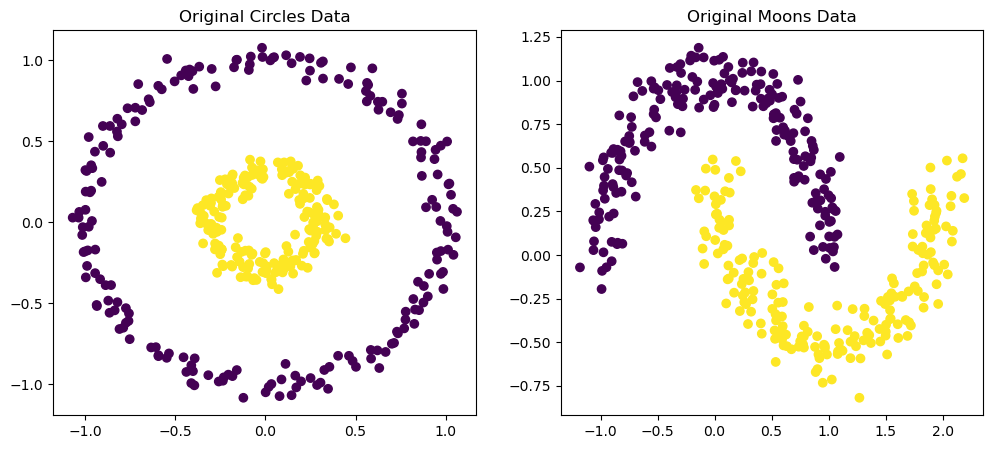

In [3]:
# Generate synthetic data using make_circles and make_moons
X_circles, y_circles = make_circles(n_samples=400, factor=0.3, noise=0.05)
X_moons, y_moons = make_moons(n_samples=400, noise=0.1)

# Plot original synthetic data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='viridis')
plt.title("Original Circles Data")

plt.subplot(1, 2, 2)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='viridis')
plt.title("Original Moons Data")

plt.show()

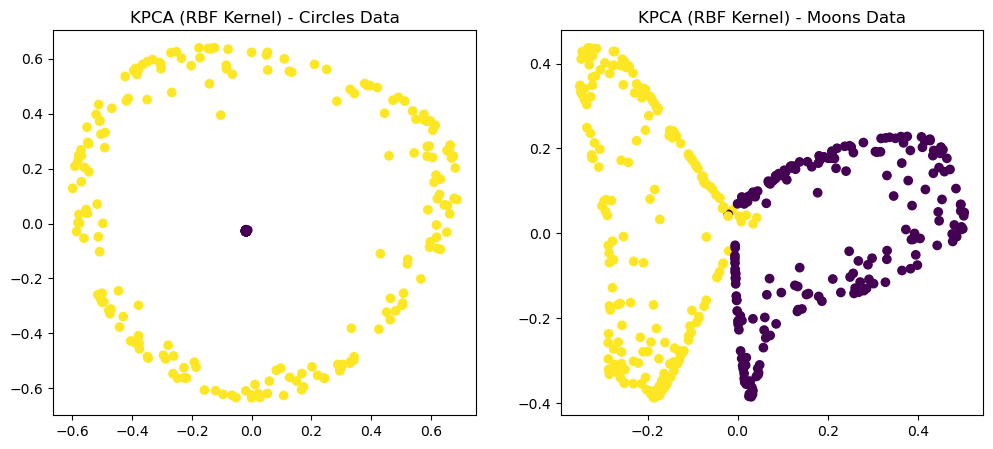

In [4]:
# Apply KPCA with RBF kernel to the circles data
kpca_rbf_circles = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca_circles = kpca_rbf_circles.fit_transform(X_circles)

# Apply KPCA with RBF kernel to the moons data
kpca_rbf_moons = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca_moons = kpca_rbf_moons.fit_transform(X_moons)

# Plot transformed data after KPCA
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_kpca_circles[:, 0], X_kpca_circles[:, 1], c=y_circles, cmap='viridis')
plt.title("KPCA (RBF Kernel) - Circles Data")

plt.subplot(1, 2, 2)
plt.scatter(X_kpca_moons[:, 0], X_kpca_moons[:, 1], c=y_moons, cmap='viridis')
plt.title("KPCA (RBF Kernel) - Moons Data")

plt.show()

After applying KPCA with an RBF kernel. the transformed data shows the separation that KPCA achieved by projecting the data into a higher-dimensional space.

---

## Using Kernel Principal Component Analysis (KPCA) for Outlier Detection Using PyOD Framework

The `KPCA` class from the `pyod.models.kpca` module is a powerful tool for unsupervised outlier detection. Kernel Principal Component Analysis (KPCA) detects outliers by performing PCA in a high-dimensional feature space determined by a kernel function. The reconstruction error in this feature space is used as the anomaly score, making KPCA particularly effective for detecting non-linear anomalies.

### Key Parameters of KPCA

- **contamination**: The proportion of outliers in the dataset.
  - Type: `float` (default=0.1)
  - Range: `(0, 0.5)`
  - Used to define the threshold on the decision function.

- **n_components**: The number of components to keep during PCA.
  - Type: `int` (default=None)
  - If `None`, all non-zero components are retained.

- **n_selected_components**: The number of principal components used for calculating outlier scores.
  - Type: `int` (default=None)
  - If not set, all principal components are used.

- **kernel**: The kernel function used to map data into a high-dimensional space.
  - Type: `str` (default='rbf')
  - Options: 
    - `'linear'`
    - `'poly'`
    - `'rbf'`
    - `'sigmoid'`
    - `'cosine'`
    - `'precomputed'`

- **gamma**: Kernel coefficient for `'rbf'`, `'poly'`, and `'sigmoid'` kernels.
  - Type: `float` (default=None)
  - If `None`, set to `1/n_features`.

- **degree**: The degree of the polynomial kernel.
  - Type: `int` (default=3)
  - Ignored by other kernels.

- **coef0**: Independent term in polynomial and sigmoid kernels.
  - Type: `float` (default=1)
  - Ignored by other kernels.

- **eigen_solver**: The algorithm used to compute the eigenvectors.
  - Type: `str` (default='auto')
  - Options: 
    - `'auto'`
    - `'dense'`
    - `'arpack'`
    - `'randomized'`

- **tol**: Convergence tolerance for the ARPACK eigen solver.
  - Type: `float` (default=0)

- **max_iter**: Maximum number of iterations for ARPACK.
  - Type: `int` (default=None)

- **remove_zero_eig**: Whether to remove components with zero eigenvalues.
  - Type: `bool` (default=False)

- **copy_X**: If `True`, copies the input data.
  - Type: `bool` (default=True)

- **n_jobs**: Number of parallel jobs to run.
  - Type: `int` (default=None)
  - `-1` uses all available cores.

- **sampling**: If `True`, only a subset of the data is used to reduce time complexity.
  - Type: `bool` (default=False)

- **subset_size**: The size of the subset used for sampling.
  - Type: `float` or `int` (default=20)

### Methods in KPCA

- **fit()**: Trains the KPCA model on the provided data.
  - **Parameters**:
    - `X`: The input data to train on (ndarray of shape `(n_samples, n_features)`).
  - **Returns**:
    - `self`: The fitted KPCA instance.
  - **Example**:
    ```python
    kpca.fit(X_train)
    ```

- **predict()**: Predicts whether each sample is an outlier or not.
  - **Parameters**:
    - `X`: The input data to predict (ndarray of shape `(n_samples, n_features)`).
    - `return_confidence`: If `True`, also returns the confidence of the prediction.
  - **Returns**:
    - `outlier_labels`: Binary labels for each sample (0 for inliers, 1 for outliers).
    - `confidence` (optional): Confidence of the prediction (only returned if `return_confidence=True`).
  - **Example**:
    ```python
    y_pred = kpca.predict(X_test)
    ```

- **decision_function()**: Computes the anomaly scores for the input data.
  - **Parameters**:
    - `X`: The input data to score (ndarray of shape `(n_samples, n_features)`).
  - **Returns**:
    - `anomaly_scores`: The anomaly scores for each sample (ndarray of shape `(n_samples,)`). Higher scores indicate a higher likelihood of being an outlier.
  - **Example**:
    ```python
    outlier_scores = kpca.decision_function(X_test)
    ```

### Training Workflow for KPCA

Here are the steps to train a KPCA model for outlier detection:

1. **Import the KPCA Class**: Start by importing the `KPCA` class from `pyod.models.kpca`.
    ```python
    from pyod.models.kpca import KPCA
    ```

2. **Initialize the KPCA Detector**: Create an instance of the KPCA class with the desired parameters.
    ```python
    kpca = KPCA(contamination=0.1, kernel='rbf', n_components=5)
    ```

3. **Train the Model**: Fit the model to the training data.
    ```python
    kpca.fit(X_train)
    ```

4. **Make Predictions**: Use the `predict` method to classify data as inliers or outliers.
    ```python
    y_pred = kpca.predict(X_test)
    ```

5. **Get Outlier Scores**: Retrieve the anomaly scores using the `decision_function`.
    ```python
    outlier_scores = kpca.decision_function(X_test)
    ```

KPCA is a versatile and effective method for detecting outliers, especially in datasets where the relationships between features are non-linear.

> **Note**: For more detailed information, you can refer to the [pyod documentation](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.kpca).

---

## Practical Example of Kernel Principal Component Analysis (KPCA) for Outlier Detection with Simulated Data

In this section, we demonstrate the application of Kernel Principal Component Analysis (KPCA) for outlier detection using simulated data. We will walk through the process of:
1. Generating sample datasets
2. Initializing the KPCA model with an appropriate kernel function
3. Transforming the data into a higher-dimensional space using KPCA
4. Calculating the reconstruction error to identify potential outliers
5. Evaluating the system's performance in detecting anomalies
6. Visualizing the results to gain insights into the identified outliers

This example will provide a hands-on understanding of how KPCA can be effectively utilized in practice for outlier detection, particularly in non-linear datasets.

KernelPCA(fit_inverse_transform=True, gamma=15, kernel='rbf', n_components=2)
Training AUC: 0.944
Testing AUC: 0.960


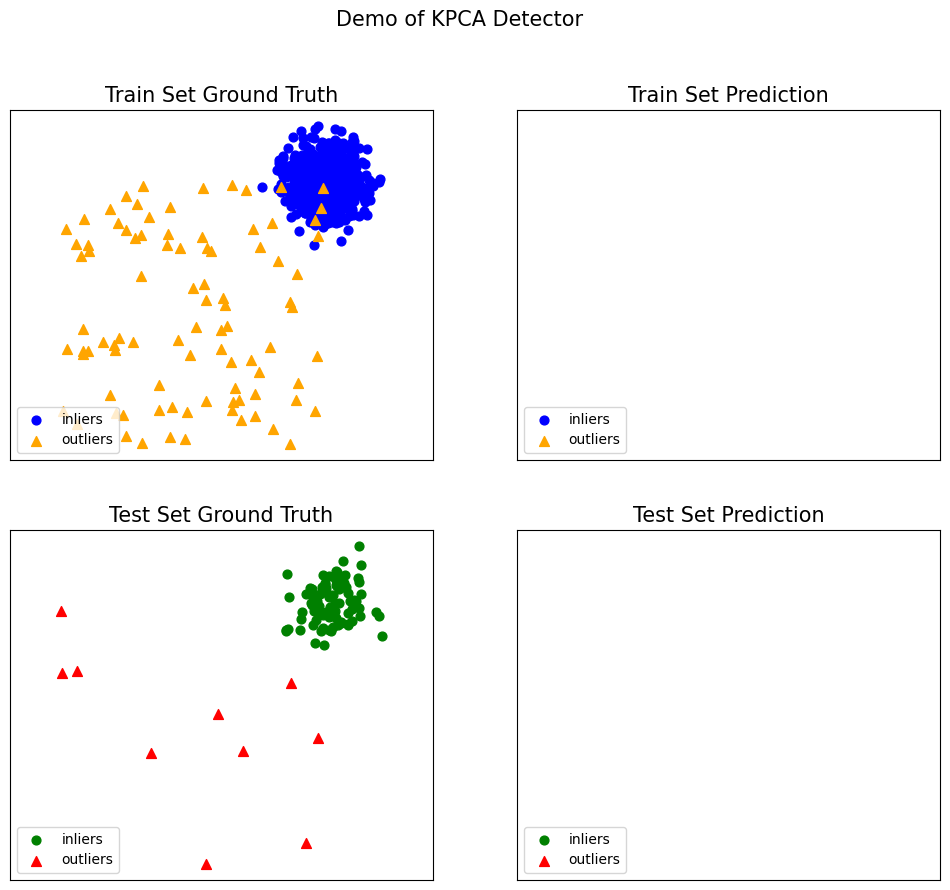

Process took 0.19927310943603516 seconds.


In [10]:
import time
from sklearn.decomposition import KernelPCA
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# Configuration
PRINT_MODEL_INFO = True                              # Set this to True to print the KPCA model details

start = time.time()
if __name__ == "__main__":
    contamination = 0.1                              # Percentage of outliers
    n_train = 900                                    # Number of training points
    n_test = 100                                     # Number of testing points

    # Generate synthetic data
    X_train, X_test, y_train, y_test = generate_sample_data(
        n_train=n_train, n_test=n_test, n_features=2, contamination=contamination, random_state=42
    )

    # Standardize the data (important for KPCA)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize the KPCA model
    kpca = KernelPCA(
        n_components=2,                           # Number of components to keep after transformation
        kernel='rbf',                             # Use RBF (Gaussian) kernel
        gamma=15,                                 # Kernel coefficient for RBF
        fit_inverse_transform=True                # Enable inverse transform for reconstruction error
    )

    # Train the KPCA model
    X_train_kpca = kpca.fit_transform(X_train)
    
    if PRINT_MODEL_INFO:
        print(kpca)                               # Print the KPCA model details
         
    # Get outlier scores based on reconstruction error
    X_train_reconstructed = kpca.inverse_transform(X_train_kpca)
    X_test_kpca = kpca.transform(X_test)
    X_test_reconstructed = kpca.inverse_transform(X_test_kpca)

    # Calculate reconstruction errors
    y_train_scores = np.linalg.norm(X_train - X_train_reconstructed, axis=1)
    y_test_scores = np.linalg.norm(X_test - X_test_reconstructed, axis=1)

    # Evaluate the model
    auc_train = roc_auc_score(y_train, y_train_scores)
    auc_test = roc_auc_score(y_test, y_test_scores)
    print(f"Training AUC: {auc_train:.3f}")
    print(f"Testing AUC: {auc_test:.3f}")

    # Visualize the results (implement your visualization function)
    visualize_results('KPCA', X_train, y_train, X_test, y_test, y_train_scores, y_test_scores)

end = time.time()

print(f"Process took {end - start} seconds.")

## Real-World Example

We will use the heart disease dataset, the same dataset used in the previous algorithm examples. For more details on the dataset, you can refer to the [ABOD algorithm notebook](03-abod-algorithm.ipynb) or visit [this link](https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/semantic/HeartDisease/HeartDisease_44.html).

### Kernel Principal Component Analysis (KPCA) Outlier Detection Workflow

To effectively leverage the Kernel Principal Component Analysis (KPCA) algorithm for outlier detection, follow these comprehensive steps:

1. **Data Preprocessing**:
   - **Handle Missing Data**: Impute or remove missing values to ensure the dataset's integrity.
   - **Eliminate Duplicates**: Remove duplicate entries to prevent bias in the outlier detection process.
   - **Encode Categorical Features**: Convert categorical variables into numerical format using techniques such as one-hot encoding or label encoding.
   - **Scale Features**: Normalize or standardize features to ensure a uniform scale across all input variables. This step is crucial for KPCA, as it relies on distances in the feature space.
   - **Dimensionality Reduction** (Optional): Use initial PCA to reduce dimensionality if dealing with a very high-dimensional dataset before applying KPCA for non-linear transformations.

2. **Applying the KPCA Detector**:
   - **Initialize the KPCA Model**: Set up the KPCA model by specifying parameters such as the kernel type (e.g., RBF), number of components, and kernel-specific parameters like gamma.
   - **Train the Model**: Fit the KPCA model to the preprocessed data. The model will map the data into a higher-dimensional feature space and reduce its dimensionality while preserving non-linear relationships.
   - **Reconstruct the Data**: Use the inverse transform function to reconstruct the data from its KPCA-transformed state and calculate reconstruction errors.
   - **Prediction**: Identify outliers by evaluating the reconstruction errors. Data points with high reconstruction errors are flagged as outliers.

3. **Performance Evaluation**:
   - **Compute Metrics**: Evaluate the performance of the KPCA model using metrics such as:
     - Precision
     - ROC AUC (Area Under the Receiver Operating Characteristic Curve)
     - Average Precision
   - **Cross-Validation**: Implement k-fold cross-validation to ensure robust performance assessment.

4. **Result Analysis and Interpretation**:
   - **Visualize Outliers**: Generate scatter plots or other visualizations to represent detected outliers visually, particularly by comparing the original data distribution with the KPCA-transformed data.
   - **Analyze Outlier Characteristics**: Identify common features or patterns among the detected outliers, especially in how they deviate from normal data in the feature space.
   - **Domain-Specific Interpretation**: Contextualize the detected outliers within the specific domain of the dataset, such as identifying potential risk factors in heart disease data.
   - **Comparative Analysis**: Compare the KPCA model's results with traditional linear PCA or other outlier detection methods to highlight the benefits of non-linear dimensionality reduction.

5. **Model Refinement** (Optional):
   - **Hyperparameter Tuning**: Adjust the KPCA model's parameters (e.g., gamma for the RBF kernel) based on the initial results to improve performance.
   - **Kernel Selection**: Experiment with different kernels (e.g., polynomial, sigmoid) to see which one best captures the data's structure and enhances the ability to detect outliers.

> **Note**:  
> To reproduce the results in the following example, ensure you have downloaded the required dataset and saved it in an accessible directory. Additionally, verify that all necessary libraries and dependencies are installed in your environment.

### Configuring the Kernel Principal Component Analysis Detector

In this example, I will configure the KPCA model with the following parameters to detect outliers:

- **Kernel**: 
  - `'rbf'` (Radial Basis Function kernel) to capture non-linear relationships in the data.
- **Gamma**: 
  - `15` to control the width of the RBF kernel.
- **Number of Components**: 
  - `n_components=2` to project the data into a 2-dimensional space.
- **Fit Inverse Transform**: 
  - `True` to enable reconstruction of the original data, allowing calculation of reconstruction error for outlier detection.

In [11]:
# Import utility functions
from data_utils import *       # This module is in the same directory as the notebooks. Ensure to have to reproduce this
                               # code chunk results (Feel free to change the placement of this module
                               # but ensure to add it the system path)


PRINT_MODEL_INFO = False

# Example of using the above functions with KPCA
if __name__ == "__main__":
    # Load the dataset
    DATA_PATH = "../../datasets/HeartDisease/HeartDisease_withoutdupl_norm_44.arff"
    df = load_arff_data(DATA_PATH)

    # Preprocess the dataset
    X, y = preprocess_heart_disease_data(df, target_name='outlier', scale=True)

    # Optionally split the dataset if needed (although for unsupervised learning, this may not be required)
    X_train, X_test, y_train, y_test = stratify_split_data(X, y, test_size=0.1, random_state=42)

    # Initialize the KPCA detector
    kpca = KPCA(
        contamination=0.4444,                # Percentage of outliers
        n_components=2,                      # Number of principal components to use
        kernel='rbf',                        # Kernel type for KPCA
        gamma=0.5                            # Kernel coefficient for RBF
    )

    # Train the KPCA model
    kpca.fit(X_train)

    if PRINT_MODEL_INFO:
        print(kpca)  # Print the KPCA model summary

    # Get predictions
    y_train_pred = kpca.predict(X_train)
    y_test_pred = kpca.predict(X_test)
    
    # Get outlier scores
    y_train_scores = kpca.decision_function(X_train)
    y_test_scores = kpca.decision_function(X_test)

    # Evaluate the model
    evaluate_model('KPCA', y_train_pred, y_train_scores, y_test_pred, y_test_scores)

    # Print the indices of the detected outliers
    outlier_indices = np.where(y_test_pred == 1)[0]
    print("Indices of the outliers:")
    print(outlier_indices)

    # Slice the data to have only the outliers
    outliers_only = X_test[outlier_indices, :]
    print(f"Number of detected outliers: {outliers_only.shape[0]}")

Training set class distribution: Counter({np.int64(0): 135, np.int64(1): 108})
Test set class distribution: Counter({np.int64(0): 15, np.int64(1): 12})
y_train has multiple classes: {np.int64(0), np.int64(1)}
y_test has multiple classes: {np.int64(0), np.int64(1)}

On Training Data:
KPCA ROC:1.0, precision @ rank n:1.0

On Test Data:
KPCA ROC:1.0, precision @ rank n:1.0
Indices of the outliers:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 24 25]
Number of detected outliers: 24


## Training Kernel Principal Component Analysis (KPCA) for Unsupervised Outlier Detection

In this section, we’ll demonstrate how to train the Kernel Principal Component Analysis (KPCA) model for unsupervised outlier detection. KPCA is particularly effective in scenarios where the goal is to identify anomalies or outliers in non-linear datasets without any labeled data. By mapping the data into a higher-dimensional space using kernel functions, KPCA captures the underlying structure of the data, making it a powerful method for detecting outliers based on reconstruction errors.

### Workflow Overview

1. **Data Preparation**:
    - We start by loading and preprocessing the dataset. Since the task is unsupervised, labels are not required for the training data.
    - The dataset is standardized to ensure that all features contribute equally to the kernel function, which is crucial for the effectiveness of KPCA.

2. **Model Initialization**:
    - We initialize the KPCA model with specified parameters such as the kernel type (`kernel`), the number of principal components (`n_components`), and kernel-specific parameters like `gamma`.
    - These parameters can be adjusted to optimize the model's performance in capturing the non-linear structure of the data and in detecting outliers.

3. **Training the KPCA Model**:
    - The KPCA model is trained on the entire dataset. During training, the model maps the data into a higher-dimensional feature space and identifies the principal components that best capture the variance in the data.
    - The model then projects the data onto these components, reducing dimensionality while preserving important non-linear relationships.

4. **Outlier Detection**:
    - After training, the model reconstructs the data from its reduced representation. The reconstruction error, which measures how well the original data is approximated, is calculated for each data point.
    - Data points with significantly higher reconstruction errors compared to others are flagged as potential outliers.

5. **Results Analysis**:
    - We will analyze the detected outliers by reviewing their reconstruction errors and how they differ from the inliers.
    - Visualization techniques will be employed to illustrate the separation between inliers and outliers in the KPCA-transformed space, providing insights into the model’s effectiveness.

(270, 14)
(270,)
outlier
no     150
yes    120
Name: count, dtype: int64
120
************************************************************************
                        Training and Prediction                         
************************************************************************
************************************************************************
                         Displaying Information                         
************************************************************************
Outliers detected: 120 out of 270
Indices of the outliers:
[  0   1   2   4   5   6   9  13  15  17  18  19  22  24  29  31  33  35
  37  40  43  44  46  48  49  51  52  53  56  57  58  59  60  61  63  64
  67  71  73  74  75  80  81  85  87  90  98 101 103 106 107 110 113 117
 118 119 120 124 129 130 131 133 135 137 143 144 147 148 149 153 156 158
 159 160 161 165 167 169 170 172 175 176 177 178 180 181 184 187 188 189
 191 193 194 198 199 205 209 210 211 217 223 224 225 226 227 

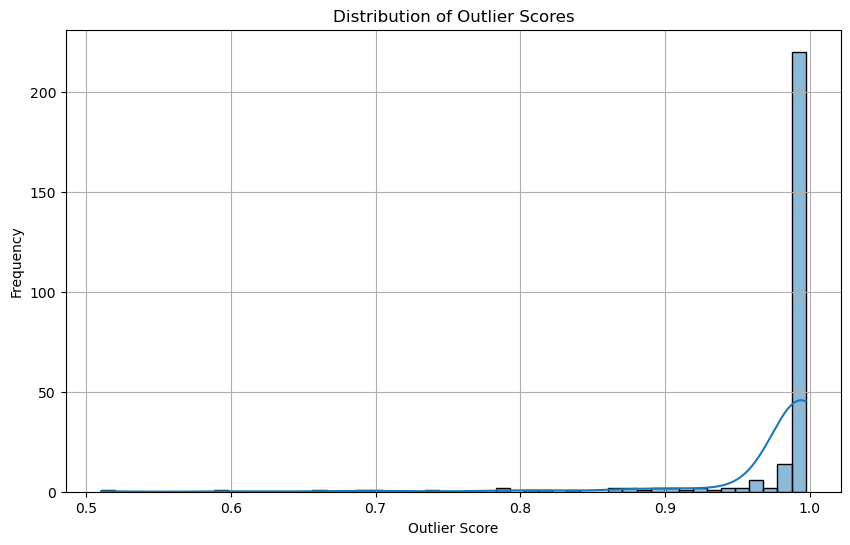

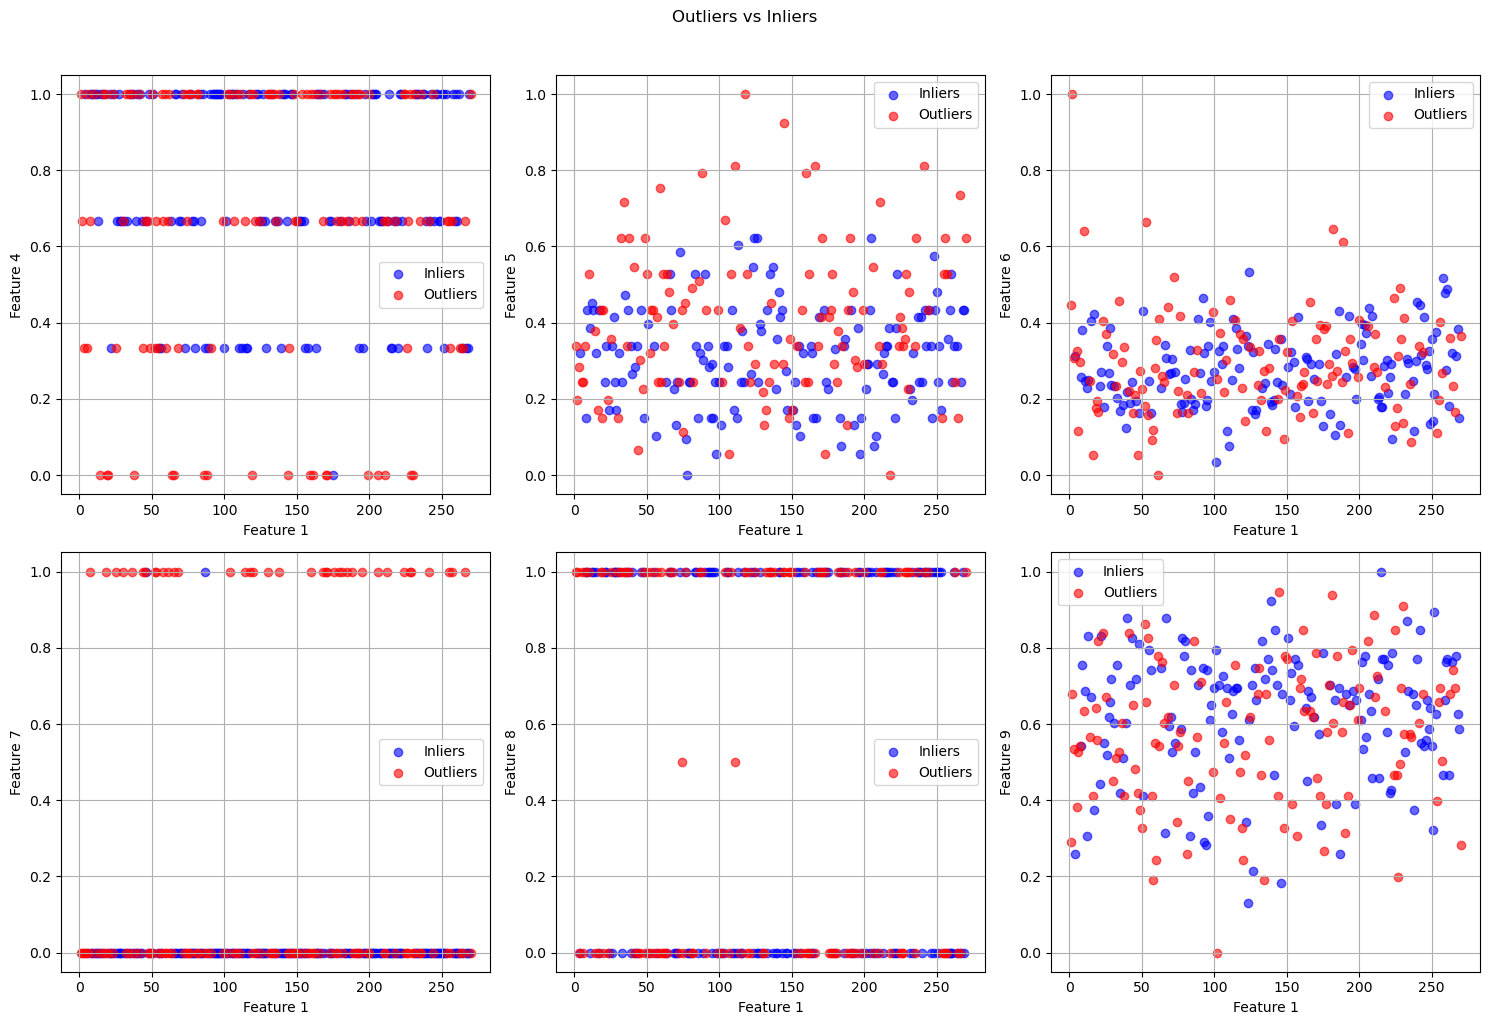

In [12]:
# Load and preprocess the dataset
df = load_arff_data(DATA_PATH)
X, y = preprocess_heart_disease_data(df, 'outlier')
print(X.shape)
print(y.shape)
print(df['outlier'].value_counts())
print(sum(y == 1))

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the KPCA model
kpca = KPCA(
    contamination=0.4444, 
    n_components=2,         # Number of components to keep after transformation
    kernel='rbf',           # Kernel type, e.g., 'rbf', 'linear', 'poly'
    gamma=0.5               # Kernel coefficient for RBF kernel
)

# Train the KPCA model
kpca.fit(X_scaled)

print_banner("*", 72, "Training and Prediction")

# Get predictions
y_pred = kpca.labels_  # binary labels (0: inliers, 1: outliers)
outlier_scores = kpca.decision_scores_  # raw outlier scores

print_banner("*", 72, "Displaying Information")
# You can now analyze the results
print(f"Outliers detected: {sum(y_pred)} out of {len(y_pred)}")

# Getting the outlier indexes
outlier_indices = np.where(y_pred == 1)[0]

# Print the indexes of the outliers
print("Indices of the outliers:")
print(outlier_indices)

# Slice the data to have only the outliers
outliers_only = X.iloc[outlier_indices, :]
print(outliers_only.shape[0])

print_banner("*", 72, "Plotting")

# Plot the distribution of outlier scores
plt.figure(figsize=(10, 6))
sns.histplot(outlier_scores, bins=50, kde=True)
plt.title("Distribution of Outlier Scores")
plt.xlabel("Outlier Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot outlier scores against selected features
plot_outliers_vs_inliers(X, y_pred=y_pred, plot_features=[3, *range(4, 9)])

---

### Fine-Tune KPCA Algorithm

In this section, we will try to find the best hyperparameters for the KPCA algorithm, specifically focusing on parameters like `gamma` and `n_components`. These hyperparameters play a crucial role in determining the performance of the KPCA model, especially in terms of its ability to detect outliers. The best combination of these parameters will be determined based on the `precision at rank n` metric.

We will be using the `hyperopt` package to optimize these hyperparameters. This package allows us to efficiently explore the hyperparameter space and identify the settings that yield the best results. I assume you already have a background in hyperparameter tuning techniques, as they are beyond the scope of this notebook tutorial.

In [14]:
from utils import precision_n_scores
# Fine the KPCA algorithm using hyperopt framework
# ===============================================

# Known contamination rate
contamination = 0.4444

# Known number of outliers
n_outliers = int(contamination * len(y))

# The search space for KPCA parameters
search_space = {
    'n_components': scope.int(hp.quniform('n_components', 1, X.shape[1], 1)),
    'gamma': hp.loguniform('gamma', np.log(1e-4), np.log(1e-1))
}

def hyperopt_objective(params, X, y, n_outliers, contamination):
    """
    Objective function for Hyperopt to optimize the KPCA parameters.

    Parameters
    ----------
    params : dict
        Dictionary containing the hyperparameters 'n_components' and 'gamma'.

    X : ndarray
        The scaled feature matrix.

    y : ndarray
        The true labels.

    n_outliers : int
        The number of true outliers.

    contamination : float
        The contamination rate (proportion of outliers).

    Returns
    -------
    dict
        Dictionary containing the loss (negative precision at rank n) and the status.
    """
    n_components = params['n_components']
    gamma = params['gamma']

    kpca = KPCA(n_components=n_components, kernel='rbf', gamma=gamma, contamination=contamination)

    # Fit the model to the data
    kpca.fit(X)

    # Predict the outlier scores
    outlier_scores = kpca.decision_scores_

    # Calculate precision at rank n
    precision_n = precision_n_scores(y, outlier_scores, n=n_outliers)
    return {'loss': -precision_n, 'status': STATUS_OK}


# Use Hyperopt to optimize the KPCA parameters
trials = Trials()
best = fmin(fn=lambda params: hyperopt_objective(params, X_train, y_train, n_outliers, contamination),
            space=search_space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(f"Best parameters: n_components={best['n_components']}, gamma={best['gamma']}")

100%|██████████| 100/100 [06:12<00:00,  3.73s/trial, best loss: -0.5714285714285714]
Best parameters: n_components=6.0, gamma=0.0024352019341630227


- We can retrain the previous supervised learning example using the found hyperparamters. 

In [15]:
# Retrain the previous example with best hyperparameters 



## KPCA in Practice

In this section, we will demonstrate the application of the KPCA algorithm on various benchmark datasets across different domains:

1.	**Computer Vision Dataset**: The well-known MNIST dataset.
2.	**Text Analysis Dataset**:   Amazon Reviews dataset.
3.	**Network Intrusion Detection Dataset**: An intrusions simulated dataset in a military network environment. 

**To do** 

`...` This section will be written later `...`

In [7]:
mnist_path = "../../datasets/Classical/24_mnist.npz"
mnist = np.load(mnist_path, allow_pickle=True)
X, y = mnist['X'], mnist['y']

print(X.shape)
print(y.shape)
print(np.count_nonzero(y)/len(y))

(7603, 100)
(7603,)
0.09206892016309351


In [8]:
amazon_path = "../../datasets/NLP_by_BERT/amazon.npz"
amazon = np.load(amazon_path, allow_pickle=True)
X, y = amazon['X'], amazon['y']

print(X.shape)
print(y.shape)
print(np.count_nonzero(y)/len(y))

(10000, 768)
(10000,)
0.05


In [9]:
## Load Intrusion datasets
train = pd.read_csv("../../datasets/networkIntrosion/Train_data.csv")
test = pd.read_csv("../../datasets/networkIntrosion/Test_data.csv")

print(train.shape)
# print(train.info())

(25192, 42)


In [10]:
print(test.shape)
# print(test.info())

(22544, 41)


In [11]:
# Check the `class` which is the target
print(train.loc[:, "class"].value_counts())

class
normal     13449
anomaly    11743
Name: count, dtype: int64


In [12]:
# Identify categorical and numerical columns
categorical_cols = [col for col in train.columns.to_list() if train[col].dtype=='object' and col !='class']
numerical_cols = [col for col in train.columns if col not in categorical_cols and col !='class']

# Prepare the data
X_train = train.drop(columns=['class']) 
y_train = train['class'].apply(lambda x: 1 if x == 'anomaly' else 0) 

# The X_test
X_test = test

In [13]:
# Apply preprocessing


In [14]:
# Apply KNN

In [15]:
# Visualize the results


## Conclusion

This notebook demonstrates the application of the **K-Nearest Neighbors Outlier Detector (ABOD)** algorithm across multiple contexts. Through theoretical exploration and practical implementation, we have showcased KNN's strengths in detecting anomalies in both artificial and real-world datasets.

---

# Supplments

Here we demonstrate a step-by-step the concepts related to Kernel Principal Component Analysis (KPCA) the theoretically and practically. 


1. **Kernel Function**

The kernel function is central to KPCA, as it implicitly maps the input data into a higher-dimensional space where linear relationships can be found. Let’s explore how to use different kernel functions.

In [5]:
from sklearn.decomposition import KernelPCA
import numpy as np

# Example data
X = np.array([
    [1, 2],
    [2, 3],
    [3, 4],
    [4, 5],
    [5, 6],
])

# Apply KPCA with different kernels
kpca_linear = KernelPCA(kernel='linear')
kpca_poly = KernelPCA(kernel='poly', degree=3, coef0=1)
kpca_rbf = KernelPCA(kernel='rbf', gamma=0.5)

X_kpca_linear = kpca_linear.fit_transform(X)
X_kpca_poly = kpca_poly.fit_transform(X)
X_kpca_rbf = kpca_rbf.fit_transform(X)

print("Linear Kernel PCA:\n", X_kpca_linear)
print("Polynomial Kernel PCA:\n", X_kpca_poly)
print("RBF Kernel PCA:\n", X_kpca_rbf)

Linear Kernel PCA:
 [[-2.82842712]
 [-1.41421356]
 [-0.        ]
 [ 1.41421356]
 [ 2.82842712]]
Polynomial Kernel PCA:
 [[-6.48506387e+01  3.65853928e+00 -9.87516339e-02]
 [-5.07215744e+01 -2.21844877e-01  1.50571570e-01]
 [-2.11465736e+01 -2.97016184e+00  2.37752326e-02]
 [ 2.95750009e+01 -2.74831696e+00 -1.26796337e-01]
 [ 1.07143786e+02  2.28178439e+00  5.12011686e-02]]
RBF Kernel PCA:
 [[-5.90028805e-01 -4.94107735e-01  3.89699824e-01  1.53189720e-01]
 [-5.75518974e-01  1.44621826e-01 -3.99524832e-01 -3.29696987e-01]
 [-1.24607198e-15  6.98971818e-01 -1.08879829e-15  3.53014535e-01]
 [ 5.75518974e-01  1.44621826e-01  3.99524832e-01 -3.29696987e-01]
 [ 5.90028805e-01 -4.94107735e-01 -3.89699824e-01  1.53189720e-01]]


2. **Non-Linear Principal Components**

In KPCA, principal components are found in the higher-dimensional feature space. The following code demonstrates the transformation of non-linearly distributed data (e.g., circles) using KPCA.

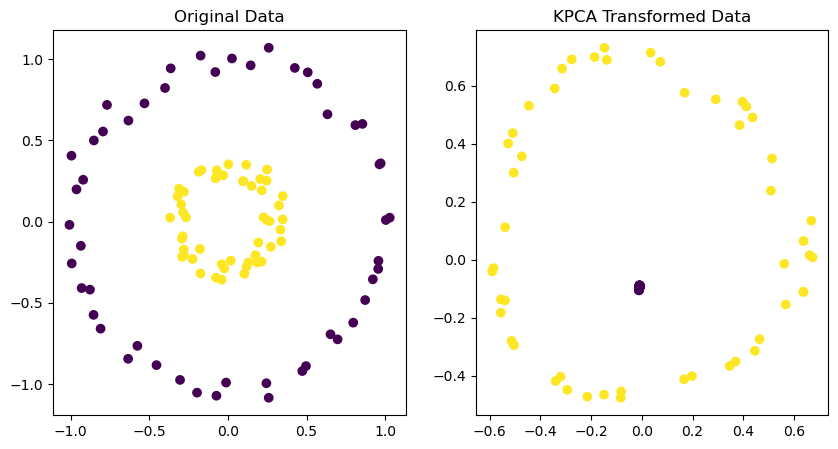

In [6]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

# Generate synthetic non-linear data (circles)
X, y = make_circles(n_samples=100, factor=0.3, noise=0.05)

# Apply KPCA with an RBF kernel
kpca = KernelPCA(kernel='rbf', gamma=15)
X_kpca = kpca.fit_transform(X)

# Plot the original data and transformed data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Data")
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.subplot(1, 2, 2)
plt.title("KPCA Transformed Data")
plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=y)
plt.show()

3. **Reconstruction Error in KPCA**

Reconstruction error in KPCA can be used to detect how well the reduced representation captures the original data. This error can be used to identify outliers.

In [7]:
from sklearn.metrics.pairwise import rbf_kernel

# Original data
X = np.array([
    [1, 2],
    [2, 3],
    [3, 4],
    [8, 9],  # This point is an outlier
])

# Apply KPCA
kpca = KernelPCA(kernel='rbf', gamma=0.5, fit_inverse_transform=True)
X_kpca = kpca.fit_transform(X)

# Inverse transform to reconstruct the data
X_reconstructed = kpca.inverse_transform(X_kpca)

# Calculate reconstruction error
reconstruction_error = np.linalg.norm(X - X_reconstructed, axis=1)
print("Reconstruction Error:\n", reconstruction_error)

# Points with high reconstruction error are likely outliers
outliers = reconstruction_error > np.mean(reconstruction_error) + np.std(reconstruction_error)
print("Outliers Detected:\n", outliers)

Reconstruction Error:
 [0.43004205 0.48629305 1.38637552 5.74971581]
Outliers Detected:
 [False False False  True]


4. **Application of KPCA to Outlier Detection**

KPCA can be directly applied to detect outliers by identifying data points with high reconstruction errors.

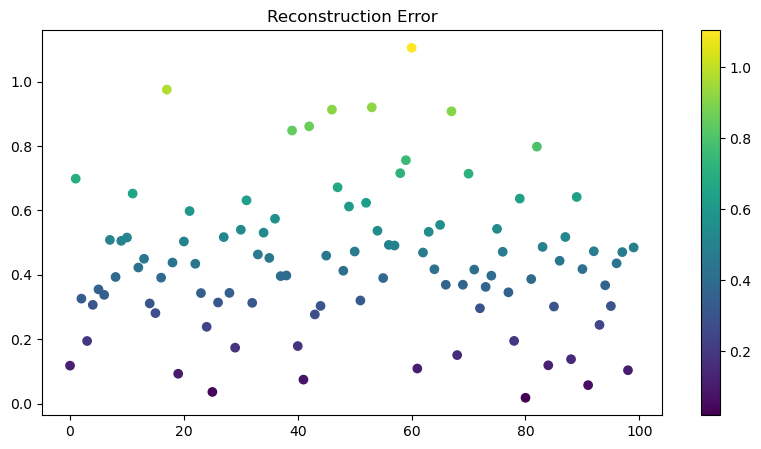

Detected Outliers:
 [False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False  True False False False False False False
  True False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


In [8]:
from sklearn.datasets import make_moons

# Generate non-linear data (moons)
X, y = make_moons(n_samples=100, noise=0.1)

# Apply KPCA
kpca = KernelPCA(kernel='rbf', gamma=10, fit_inverse_transform=True)
X_kpca = kpca.fit_transform(X)

# Reconstruct the data
X_reconstructed = kpca.inverse_transform(X_kpca)

# Calculate reconstruction error
reconstruction_error = np.linalg.norm(X - X_reconstructed, axis=1)

# Plot the reconstruction error
plt.figure(figsize=(10, 5))
plt.title("Reconstruction Error")
plt.scatter(range(len(reconstruction_error)), reconstruction_error, c=reconstruction_error, cmap='viridis')
plt.colorbar()
plt.show()

# Mark outliers based on reconstruction error threshold
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
outliers = reconstruction_error > threshold
print("Detected Outliers:\n", outliers)

5. **Advantages and Challenges of KPCA in Outlier Detection**

To demonstrate the advantages and challenges, let’s visualize the effects of different kernel choices and parameter tuning on the reconstruction error and outlier detection.

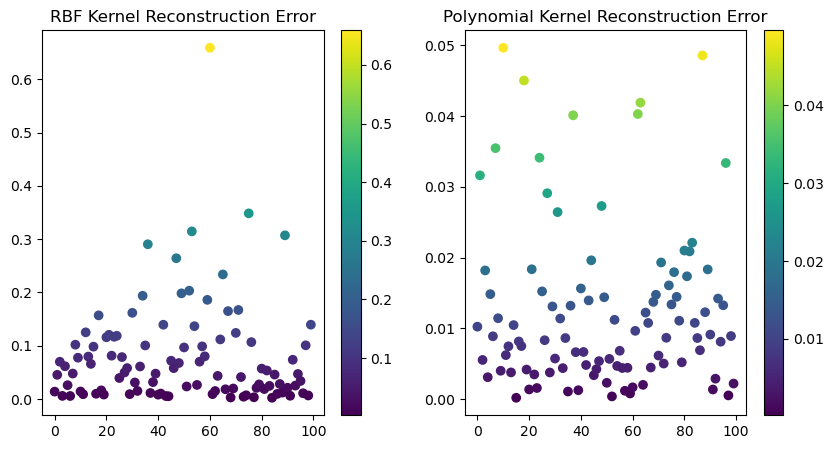

In [9]:
# Apply KPCA with different kernels and parameters
kpca_rbf = KernelPCA(kernel='rbf', gamma=1, fit_inverse_transform=True)
kpca_poly = KernelPCA(kernel='poly', degree=3, coef0=1, fit_inverse_transform=True)

# Fit and transform the data
X_kpca_rbf = kpca_rbf.fit_transform(X)
X_kpca_poly = kpca_poly.fit_transform(X)

# Reconstruct the data
X_reconstructed_rbf = kpca_rbf.inverse_transform(X_kpca_rbf)
X_reconstructed_poly = kpca_poly.inverse_transform(X_kpca_poly)

# Calculate reconstruction errors
error_rbf = np.linalg.norm(X - X_reconstructed_rbf, axis=1)
error_poly = np.linalg.norm(X - X_reconstructed_poly, axis=1)

# Visualize the reconstruction errors
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("RBF Kernel Reconstruction Error")
plt.scatter(range(len(error_rbf)), error_rbf, c=error_rbf, cmap='viridis')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Polynomial Kernel Reconstruction Error")
plt.scatter(range(len(error_poly)), error_poly, c=error_poly, cmap='viridis')
plt.colorbar()

plt.show()

6. **Practical Considerations**

When applying KPCA to real-world data, consider the following:

  - Kernel Choice: Different kernels may capture different structures in the data, which can significantly impact outlier detection.
  - Parameter Tuning: Tuning parameters like gamma for RBF kernels or degree for polynomial kernels is crucial for optimal performance.
  - Scalability: For large datasets, consider using approximate methods or dimensionality reduction techniques before applying KPCA.